In [2]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
import maxr
import h5py

#### Integrating given an explicity velocity function

Define a blinking vortex function

In [78]:
def vortex(x0, y0, gamma):
    """ Returns a function to give a vortex flow centered at r,
        with strength Gamma
    """
    def _flow(x, y):
        x = numpy.asarray(x)
        y = numpy.asarray(y)
        rsq = (x - x0) ** 2 + (y - y0) ** 2
        return (gamma * (y - y0) / (2 * numpy.pi * rsq),
                -gamma * (x - x0) / (2 * numpy.pi * rsq))
    return _flow

def tick(t, T): 
    """ Adding some time dependence! 
    """
    return numpy.clip(numpy.sin(2 * numpy.pi * t / T), 0, 1.01)
    
def tock(t, T): 
    """ Adding some time dependence! 
    """
    return numpy.clip(-numpy.sin(2 * numpy.pi * t / T), 0, 1.01)

def blink(gamma, period):
    """ The blinking vortex flow
    """
    # Generate two vortices
    vortices = [vortex(x, 0, gamma) for x in (-0.5, 0.5)]
    
    # Wrap in flow with time dependence
    def _flow(x, y, t):
        vortex = [v(x, y) for v in vortices]
        return vortex[0][0] * tick(t, period) + vortex[1][0] * tock(t, period), \
               vortex[0][1] * tick(t, period) + vortex[1][1] * tock(t, period)
    return _flow

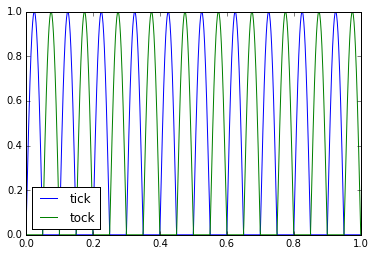

In [109]:
period = 0.1
ts = numpy.linspace(0,1,1000)
plt.plot(ts, tick(ts, period), label='tick')
plt.plot(ts, tock(ts, period), label='tock')
plt.legend(loc='best')

In [110]:
flow = blink(gamma=1, period=0.5)

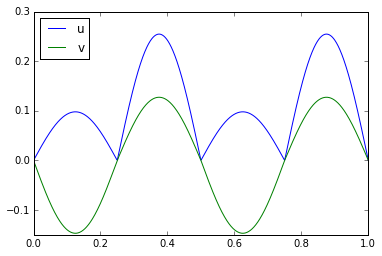

In [111]:
u, v = flow(0.25, 0.5, ts)
plt.plot(ts, u, label='u')
plt.plot(ts, v, label='v')
plt.legend(loc='best')

We need to calculate the velocity divergence and time derivative at given points

In [92]:
x, y = numpy.linspace(-1, 1), numpy.linspace(-1, 1)
xs, ys = numpy.meshgrid(x, y)
dx, dy = x[1] - x[0], y[1] - y[0]
grad = [numpy.gradient(vel, dx, dy, edge_order=2) 
        for vel in flow(xs, ys, 0.13)]
h = 0.001
forward = flow(xs, ys, 0.13 + h)
back = flow(xs, ys, 0.13 - h)
time_derivative = [(forward[idx] - back[idx]) / (2 * h) for idx in range(2)]

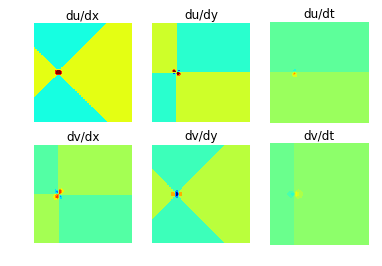

In [93]:
f, axes = plt.subplots(2, 3)
for i in (0, 1):
    df = 'dv' if i else 'du'
    for j in (0, 1):
        dx = 'dy' if j else 'dx'
        ax = axes[i, j]
        ax.contourf(xs, ys, grad[i][j], vmin=-50, vmax=50)
        ax.set_aspect('equal')
        ax.set_axis_off()
        ax.set_title(df + '/' + dx)
    
    ax = axes[i, 2]
    ax.contourf(xs, ys, time_derivative[i], vmin=-10, vmax=10)
    ax.set_axis_off()
    ax.set_title(df + '/dt')

#### Integrating given a velocity field from file

Given a velocity field generating function, calculate values from a grid and write out to file

In [258]:
import numpy
from scipy.interpolate import RegularGridInterpolator
import h5py

def make_flow_file(flow, filename=None, xgrid=None, ygrid=None, tgrid=None):
    """ Write a flow function to file
    """
    filename = filename or 'flow.hdf5'
    
    # Define the grid
    minx, maxx, nx = xgrid or (-2, 2, 40)
    miny, maxy, ny = ygrid or (-2, 2, 40)
    mint, maxt, nt = tgrid or (0, 2, 20)
    
    # Write to file
    with h5py.File(filename, 'w') as fhandle:
        # Create axes datasets
        fhandle['x'] = numpy.linspace(minx, maxx, nx)
        fhandle['y'] = numpy.linspace(miny, maxy, ny)
        fhandle['t'] = ts = numpy.linspace(mint, maxt, nt)

        # Create velocity datasets
        u = fhandle.require_dataset('u', shape=(nx, ny, nt), dtype=numpy.float32)
        v = fhandle.require_dataset('v', shape=(nx, ny, nt), dtype=numpy.float32)
        for comp in (u, v):
            for idx, ax in enumerate('xyt'):
                comp.dims[idx].label = ax

        # Write velocity datasets to file
        xs, ys = grid(fhandle)
        for idx, t in enumerate(ts):
            u, v = flow(xs, ys, t)
            fhandle['u'][:, :, idx] = u
            fhandle['v'][:, :, idx] = v
        
        # Create derivative datasets
        for idx, ax in enumerate('xyt'):
            for comp in 'uv':
                key = 'd{0}/d{1}'.format(comp, ax)
                fhandle.require_dataset(key, shape=(nx, ny, nt), dtype=numpy.float32)
                fhandle[key].dims[idx].label = ax
        
        # x and y derivatives
        dx = fhandle['x'][1] - fhandle['x'][0]
        dy = fhandle['y'][1] - fhandle['y'][0]
        for idx, t in enumerate(fhandle['t']):
            for comp in 'uv':
                key = 'd{0}/d'.format(comp)
                dcdx, dcdy = numpy.gradient(fhandle[comp][:, :, idx], 
                                            dx, dy, edge_order=2)
                fhandle[key + 'x'][:, :, idx] = dcdx
                fhandle[key + 'y'][:, :, idx] = dcdy
        
        # t derivative
        dt = numpy.diff(fhandle['t'])
        for comp in 'uv':
            key = 'd{0}/dt'.format(comp)
            fhandle[key][..., 0] = 0
            fhandle[key][..., 1:] = numpy.diff(fhandle[comp], axis=2) / dt

class Flow(object):
    
    def __init__(self, filename):
        self.data = h5py.File(filename)
    
    def close(self):
        self.data.close()
    
    def __call__(self, key):
        """ Returns an interpolation for the given value for the snapshot at idx
        """
        return RegularGridInterpolator(
            points=(self.data['x'], self.data['y'], self.data['t']), 
            values=self.data[key])

    def info(self):
        """ Print some info about the keys defined here
        """
        for key in self.data.keys():
            try:
                print(key, self.data[key].shape)
            except AttributeError:
                # We have a group
                group = self.data[key]
                for key2 in group.keys():
                    print(key + '/' + key2, group[key2].shape)
                    
    def snapshot(self, idx):
        """ Return a velocity field snapshot
        """
        return self.data['u'][:, :, idx], self.data['v'][:, :, idx]

    def grid(self):
        """ Return the spatial sampling grid
        """        
        return numpy.meshgrid(self.data['x'], self.data['y'])
    
    def plot_snapshots(self, plot_every=1):
        """ Plot the snapshots
        """
        # Get info on axes from file
        ts = self.data['t'][::plot_every]
        x, y = self.grid()

        # Make figure
        nplots, ncol = len(ts), 5
        fig, axes = plt.subplots(nplots // ncol, ncol)
        fig.set_size_inches(3 * ncol, 3 * (nplots // ncol))
        for idx, (t, ax) in enumerate(zip(ts, axes.ravel())):
            u, v = self.snapshot(idx * plot_every)
            ax.quiver(x, y, u, v, 
                      pivot='mid', angles='xy', 
                      scale_units='xy', scale=1.5)
            ax.set_axis_off()
            ax.set_aspect('equal')
            ax.set_title('t={0:0.2}'.format(t))

Define a blinking flow, write velocity fields out to file

In [259]:
flow = blink(gamma=1, period=0.5)

fname = 'blink.hdf5'
# make_flow_file(flow, filename=fname,
#                tgrid=(0, 1, 100))

Check that everything got made ok

In [260]:
f = Flow(fname)
f.info()

du/dt (40, 40, 100)
du/dx (40, 40, 100)
du/dy (40, 40, 100)
dv/dt (40, 40, 100)
dv/dx (40, 40, 100)
dv/dy (40, 40, 100)
t (100,)
u (40, 40, 100)
v (40, 40, 100)
x (40,)
y (40,)


In [261]:
# f.plot_snapshots(plot_every=2)

In [262]:
dudt = f('du/dt')

In [263]:
dudt([0.5, 0.5, 0.1])

array([ 0.29451572])

In [ ]:
def flow_forcing(f, r, w, t, params):
    """ Calculate the instantaneous terms using the flow forcing
    """
    R, S = params.R, params.S
    gx = (p.R - 1) * f('du/dt')(r) - numpy.dot(flow['u'] + w, ) - p.R / p.S * w
    

In [ ]:
flow_forcing(
    numpy.array([-0.02, -0.02]), 
    numpy.array([0.02, 0.02]), 
    numpy.array([0, 0]))

In [ ]:
def bashforth_adams(fs, ts):
    """ Integrate a function through time using a Bashforth-Adams method
    """
    